In [156]:
import cv2
import numpy as np
import os
from sklearn.cluster  import KMeans
from matplotlib import pyplot as plt
%matplotlib inline

### 基于SIFT,BOW的图像检索
#### 1、SIFT提取每幅图像的特征点
#### 2、聚类获取视觉单词中心（聚类中心），构造视觉单词词典
#### 3、将图像特征点映射到视觉单词上，得到图像特征
#### 4、计算待检索图像的最近邻图像

In [249]:
#  根据图像数据文件夹路径获取所有图片路径

training_path='C:\\Users\\Euler\\Pictures\\Saved Pictures\\'   #训练样本文件夹路径
training_names=os.listdir(training_path)
# 保留所有图片
pic_names=['bmp','jpg','png','tiff','gif','pcx','tga','exif','fpx','svg','psd','cdr','pcd','dxf','ufo','eps','ai','raw','WMF']
for name in training_names:
    file_format=name.split('.')[-1]
    if file_format not in pic_names:
        training_names.remove(name)
num_words=1000  # 聚类中心数

img_paths=[]   # 所有图片路径
for name in training_names:
    img_path=os.path.join(training_path,name)
    img_paths.append(img_path)

In [248]:
img_paths

['C:\\Users\\Euler\\Pictures\\Saved Pictures\\1.jpg',
 'C:\\Users\\Euler\\Pictures\\Saved Pictures\\10.jpg',
 'C:\\Users\\Euler\\Pictures\\Saved Pictures\\11.jpg',
 'C:\\Users\\Euler\\Pictures\\Saved Pictures\\2.jpg',
 'C:\\Users\\Euler\\Pictures\\Saved Pictures\\3.jpg',
 'C:\\Users\\Euler\\Pictures\\Saved Pictures\\4.jpg',
 'C:\\Users\\Euler\\Pictures\\Saved Pictures\\5.jpg',
 'C:\\Users\\Euler\\Pictures\\Saved Pictures\\7.jpg',
 'C:\\Users\\Euler\\Pictures\\Saved Pictures\\8.jpg',
 'C:\\Users\\Euler\\Pictures\\Saved Pictures\\9.jpg',
 'C:\\Users\\Euler\\Pictures\\Saved Pictures\\a1.jpg',
 'C:\\Users\\Euler\\Pictures\\Saved Pictures\\cat.jpg',
 'C:\\Users\\Euler\\Pictures\\Saved Pictures\\dog.jpg',
 'C:\\Users\\Euler\\Pictures\\Saved Pictures\\IMG_20170818_145523.jpg',
 'C:\\Users\\Euler\\Pictures\\Saved Pictures\\IMG_20170818_145530.jpg',
 'C:\\Users\\Euler\\Pictures\\Saved Pictures\\sift_keypoints.jpg',
 'C:\\Users\\Euler\\Pictures\\Saved Pictures\\u=1697624658,4154934616&fm=26&gp=0

In [198]:
def getClusterCentures(img_paths,dataset_matrix,num_words):
    '''
    获取聚类中心
    
    img_paths:图像数据中所有图像路径
    dataset_matrix：图像数据的矩阵表示   注：img_paths dataset_matrix这两个参数只需要指定一个
    num_words:聚类中心数
    '''
    sift_det=cv2.xfeatures2d.SIFT_create()
    des_list=[]  # 特征描述
    des_matrix=np.zeros((1,128))
    if img_paths!=None:
        for path in img_paths:
            img=cv2.imread(path)
            gray=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
            kp,des=sift_det.detectAndCompute(gray,None)
            if des!=None:
                des_matrix=np.row_stack((des_matrix,des))
            des_list.append(des)
    elif dataset_matrix!=None:
        for gray in range(dataset_matrix.shape[0]):
            kp,des=sift_det.detectAndCompute(gray,None)
            if des!=None:
                des_matrix=np.row_stack((des_matrix,des))
            des_list.append(des)
    else:
        raise ValueError('输入不合法')
    
    des_matrix=des_matrix[1:,:]   # the des matrix of sift

    # 计算聚类中心  构造视觉单词词典
    kmeans=KMeans(n_clusters=num_words,random_state=33)
    kmeans.fit(des_matrix)
    centres = kmeans.cluster_centers_  # 视觉聚类中心
    
    return centres,des_list

In [250]:
centres,des_list=getClusterCentures(img_paths=img_paths,num_words=num_words,dataset_matrix=None)

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [227]:
des_list[0].shape

(555, 128)

In [189]:
kmeans.cluster_centers_.shape

(1000, 128)

In [190]:
np.sum(np.sum(img_features[24]))

130.0

In [200]:
# 将特征描述转换为特征向量
def des2feature(des,num_words,centures):
    '''
    des:单幅图像的SIFT特征描述
    num_words:视觉单词数/聚类中心数
    centures:聚类中心坐标   num_words*128
    return: feature vector 1*num_words
    '''
    img_feature_vec=np.zeros((1,num_words),'float32')
    for i in range(des.shape[0]):
        feature_k_rows=np.ones((num_words,128),'float32')
        feature=des[i]
        feature_k_rows=feature_k_rows*feature
        feature_k_rows=np.sum((feature_k_rows-centures)**2,1)
        index=np.argmax(feature_k_rows)
        img_feature_vec[0][index]+=1
    return img_feature_vec

In [206]:
def get_all_features(des_list,num_words):
    # 获取所有图片的特征向量
    allvec=np.zeros((len(des_list),num_words),'float32')
    for i in range(len(des_list)):
        if des_list[i]!=None:
            allvec[i]=des2feature(centures=centres,des=des_list[i],num_words=num_words)
    return allvec

#### 经过之前的操作，我们已经成功通过词袋表示法将SIFT提取的特征表示出来
#### 接下来计算待检索图像最近邻图像

In [127]:
def getNearestImg(feature,dataset,num_close):
    '''
    找出目标图像最像的几个
    feature:目标图像特征
    dataset:图像数据库
    num_close:最近个数
    return:最相似的几个图像
    '''
    features=np.ones((dataset.shape[0],len(feature)),'float32')
    features=features*feature
    dist=np.sum((features-dataset)**2,1)
    dist_index=np.argsort(dist)
    return dist_index[:num_close]

In [259]:
def showImg(target_img_path,index,dataset_paths):
    '''
    target_img:要搜索的图像
    dataset_paths：图像数据库所有图片的路径
    显示最相似的图片集合
    '''
    # get img path
    paths=[]
    for i in index:
        paths.append(dataset_paths[i])
        
    plt.figure(figsize=(10,20))    #  figsize 用来设置图片大小
    plt.subplot(432),plt.imshow(plt.imread(target_img_path)),plt.title('target_image')
    
    for i in range(len(index)):
        plt.subplot(4,3,i+4),plt.imshow(plt.imread(paths[i]))
    plt.show()

In [216]:
# 暴力搜索
def retrieval_img(img_path,img_dataset,centures,img_paths):
    '''
    检索图像，找出最像的几个
    img:待检索的图像
    img_dataset:图像数据库 matrix
    num_close:显示最近邻的图像数目
    centures:聚类中心
    img_paths:图像数据库所有图像路径
    '''
    num_close=9
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    kp,des=sift_det.detectAndCompute(img,None)
    feature=des2feature(des=des,centures=centures,num_words=num_words)
    sorted_index=getNearestImg(feature,img_dataset,num_close)
    
    showImg(img_path,sorted_index,img_paths)

In [251]:
# test
img_features=get_all_features(des_list=des_list,num_words=num_words)

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  """


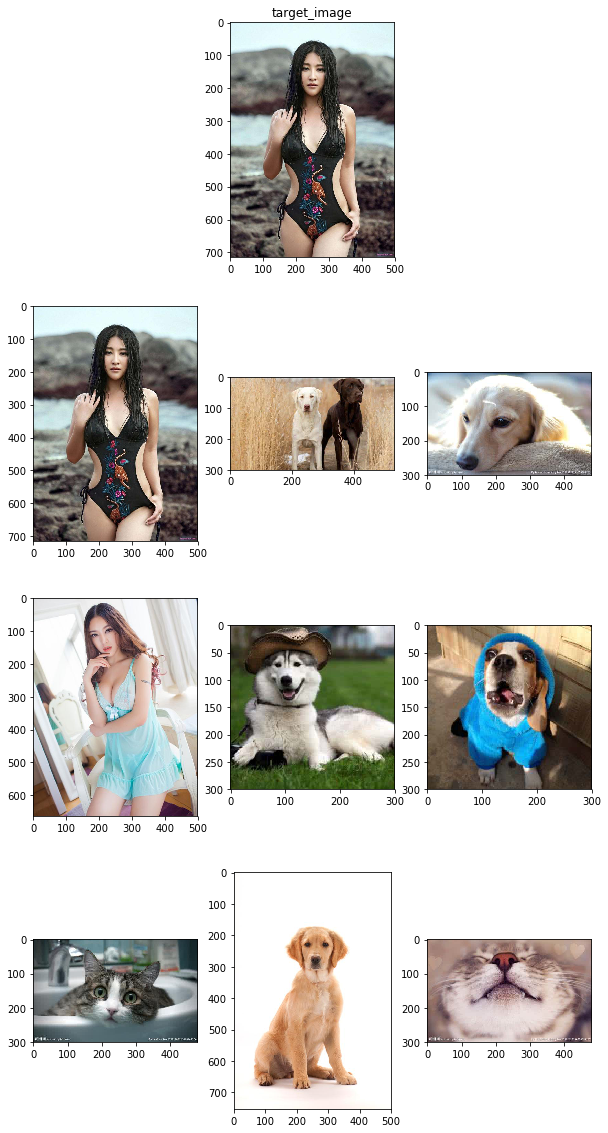

In [261]:
path='C:\\Users\\Euler\\Pictures\\Saved Pictures\\3.jpg'

retrieval_img(path,img_features,centres,img_paths)


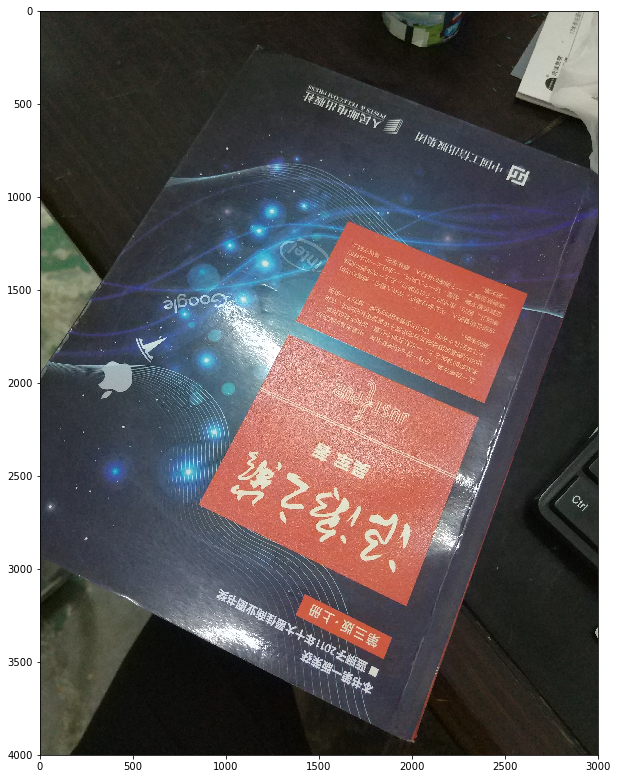

In [256]:
pic=plt.imread(path)
plt.figure(figsize=(10,20))
plt.imshow(pic)
plt.show()